### **Clasificación de galaxias con Aprendizaje Profundo: Redes Neuronales Convolucionales (CNN)**

**Objetivo:** El objetivo de este tutorial es ilustrar una clasificación multiclase supervisada haciendo uso de redes neuronales convolucionales. En este tutorial utiliza el conjunto de datos Galaxy10 SDSS, recopilado del proyecto astroNN, el cuál esta compuesto por 21,2785 imágenes de 69 x 69 pixeles de 3 canales (RGB) y sus etiquetas. Las imágenes se obtuvieron del proyecto Sloan Digital Sky Survey SDSS y las etiquetas de Galaxy Zoo.

In [1]:
#Importar las librerías necesarias
import h5py
import numpy as np
import pylab as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


### 1. Exploración del conjunto de datos

In [2]:
# Leer y guardar las imágenes y etiquetas
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

In [4]:
# Se definen las siguientes funciones para graficar una muestra de las imágenes
def get_images(labels):
    ''' Parámetros:  
            labels: Vector de etiquetas
        Salida: 
            classes: Vector de clases 
            images_to_print: Tensor de imágenes muestra correspondientes al vector de clases de salida
    '''
    classes=[]
    images_to_print=[]
    for i in range(labels.shape[0]):
        if labels[i] not in classes and len(classes)<=10:
                classes.append(labels[i])
                images_to_print.append(images[i])
    return (classes, images_to_print)

def plot_images(classes, images_to_print):
    ''' 
    '''
    fig = plt.figure(figsize=(10,4))
    columns = 5
    rows = 2
    plt.subplots_adjust(left=0.1,top=0.9,right=0.9,bottom=0.1,wspace=0.3,hspace=0.3)
    #plt.title('Muestra de imágenes')
    for i in range(len(classes)): 
        ind = classes.index(i)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(images_to_print[ind])
        plt.title('Clase {}'.format(i))
    plt.show()


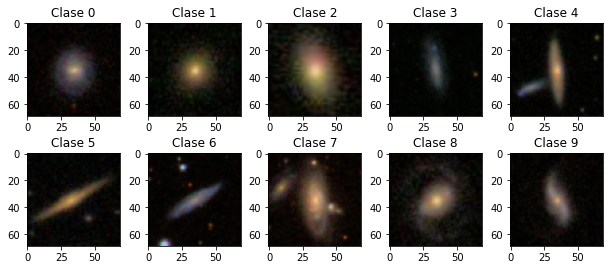

In [5]:
#Visualizar una imagen de cada clase 
classes, images_to_print=get_images(labels)
plot_images(classes, images_to_print)

### 2. Entrenamiento del modelo
A continuación se muestra la definición y construcción del modelo de red neuronal convolucional (CNN) implementado, así como su entrenamiento y el predictor obtenido como resultado del entrenamiento.

In [3]:
# Convertir las etiquetas en 10 clases categóricas
labels = utils.to_categorical(labels, 10)

In [4]:
#Separar los datos en conjunto de entrenamiento y conjunto de pruebas
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

In [5]:
#Escalamos las imágenes a un rango de  [0, 1]
train_images = train_images/ 255.
test_images = test_images/ 255.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

In [7]:
# Definimos el modelo de la red neuronal
CNN = Sequential(name='CNN')
CNN.add(Input(shape=(69, 69, 3)))
CNN.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'))
CNN.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu'))

CNN.add(MaxPool2D(pool_size=(4, 4)))

CNN.add(Flatten())
CNN.add(Dropout(rate=0.2))
CNN.add(Dense(units=256,  activation='relu'))
CNN.add(Dropout(rate=0.2))

CNN.add(Dense(units=128,  activation='relu'))
CNN.add(Dense(units=10,  activation='softmax'))

CNN.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2312)              0         
                                                                 
 dropout (Dropout)           (None, 2312)              0         
                                                                 
 dense (Dense)               (None, 256)               592128    
                                                               

In [8]:
# Compilar y entrenar el modelo. Se guardan los valores de la función de pérdida y accuracy con el objeto history.
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = CNN.fit(x=train_images, y=train_labels, epochs=20, validation_split=0.2)

Epoch 1/20
436/436 [==============================] - 41s 90ms/step - loss: 1.4470 - accuracy: 0.4307 - val_loss: 1.1363 - val_accuracy: 0.5505
Epoch 2/20
436/436 [==============================] - 32s 73ms/step - loss: 1.0823 - accuracy: 0.5925 - val_loss: 1.0049 - val_accuracy: 0.6386
Epoch 3/20
436/436 [==============================] - 27s 62ms/step - loss: 0.9866 - accuracy: 0.6310 - val_loss: 0.9143 - val_accuracy: 0.6629
Epoch 4/20
436/436 [==============================] - 29s 65ms/step - loss: 0.9236 - accuracy: 0.6543 - val_loss: 0.8815 - val_accuracy: 0.6827
Epoch 5/20
436/436 [==============================] - 32s 73ms/step - loss: 0.8759 - accuracy: 0.6706 - val_loss: 0.8296 - val_accuracy: 0.6985
Epoch 6/20
436/436 [==============================] - 31s 72ms/step - loss: 0.8391 - accuracy: 0.6868 - val_loss: 0.8561 - val_accuracy: 0.6879
Epoch 7/20
436/436 [==============================] - 31s 72ms/step - loss: 0.7972 - accuracy: 0.7010 - val_loss: 0.8103 - val_accuracy:

In [9]:
#Evaluar el desempeño del modelo con ambos conjuntos de datos
print("Conjunto de entrenamiento y validación: ", CNN.evaluate(x=train_images, y=train_labels)) 
print("Conjunto de prueba: ", CNN.evaluate(x=test_images, y=test_labels)) 

545/545 [==============================] - 16s 29ms/step - loss: 0.4235 - accuracy: 0.8606
Conjunto de entrenamiento y validación:  [0.4234614074230194, 0.860569179058075]
137/137 [==============================] - 5s 33ms/step - loss: 0.8268 - accuracy: 0.7287
Conjunto de prueba:  [0.8267725110054016, 0.7287124395370483]


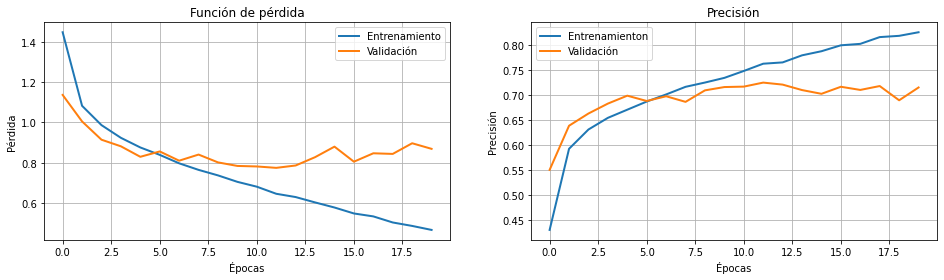

In [10]:
#Graficar la función de pérdida y la métrica de precisión 
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title('Función de pérdida')
plt.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
plt.plot(history.history['val_loss'], label='Validación', linewidth=2)
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title('Precisión')
plt.plot(history.history['accuracy'], label='Entrenamienton', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

In [37]:
#Generar las predicciones con el conjunto de prueba.
predicted_labels = CNN.predict(test_images)
prediction_class = np.argmax(predicted_labels, axis=1)
test_class = np.argmax(test_labels, axis=1)

#Crear la matriz de confusión.
confusion_matrix = np.zeros((10,10))
for counter, i in enumerate(prediction_class):
    confusion_matrix[i, test_class[counter]] += 1

confusion_matrix=confusion_matrix.astype(int)

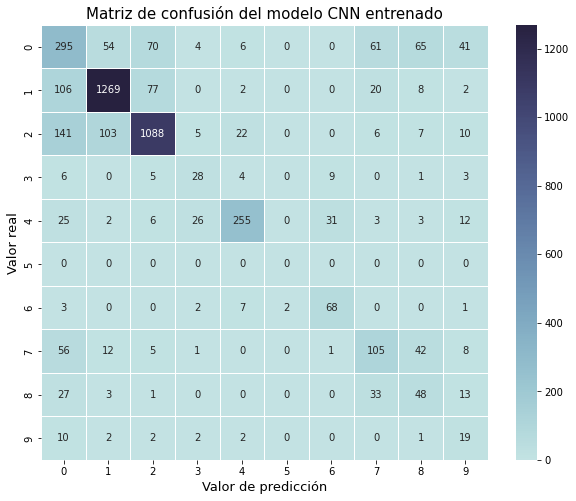

In [87]:
#Graficar la matriz de confusión del modelo.
plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap =sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), linewidths=0.5)
plt.title('Matriz de confusión del modelo CNN entrenado', fontsize=15)
plt.xlabel('Valor de predicción',fontsize=13)
plt.ylabel('Valor real',fontsize=13)
plt.show()